# Group Data Analysis PCA 1st Trial
* Version: '0.0.4'
* Date: 2021-05-03
* Author: Jea Kwon
* Description: Data Analysis

In [1]:
from avatarpy import Avatar
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from scipy.stats import zscore
cf.go_offline(connected=True)

In [2]:
root = r"C:\Users\Jay\Desktop\avatar_young_adult\data\best1_20210503"

In [3]:
avatars = dict(
    wt=dict(
        young=[],
        adult=[],
    ),
    ko=dict(
        young=[],
        adult=[],
    )
)
for path, subdirs, files in os.walk(root):
    for name in files:
        if name.lower().endswith('.csv'):
            csv_path = os.path.join(path, name)
            age = os.path.basename(os.path.dirname(path))
            genotype = os.path.basename(os.path.dirname(os.path.dirname(path)))
            
            avatars[genotype][age].append(Avatar(csv_path=csv_path, ID=name))

## Create walking event data
### Definition of walking
- Moved more than 5 cm in 1 second(20=Frame)

In [4]:
ava = avatars['wt']['young'][0]

<AxesSubplot:>

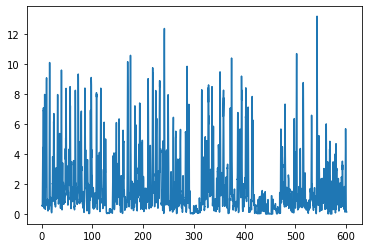

In [5]:
ava.distance['anus'].rolling(20).sum().plot()

Rolling 20 Sum --> 20 frame cumulative moving distance.  
If this value is over 5, than it means animal moved more than 5 cm in 1 second because frame rate is 20

## Event Search function

In [6]:
boo = (ava.distance['anus'].rolling(20).sum()>5).values # boolean array

In [7]:
def get_event_indices(boo, event_length):
    """Returns list of event indices.
    
    ex) [(start 1, end 1), (start 2, end 2), (start 3, end 3), ..., (start N, end N)]
    """
    indices = np.arange(len(boo))
    condition = np.nonzero(boo[1:] != boo[:-1])[0] + 1
    split_indices = np.split(indices, condition)
    true_indices = split_indices[0::2] if boo[0] else split_indices[1::2]
    event_indice_pair = [(idx[0]-event_length+1, idx[0]+1) for idx in true_indices]
    return event_indice_pair

## Validation of event search

In [8]:
event_indices = get_event_indices(boo, 20)
for i, idx in enumerate(event_indices):
    s = ava.distance['anus'][ava.index[idx[0]:idx[1]]].sum()
    print(i, s)


0 5.200178407841432
1 5.625049631210659
2 5.013328178598617
3 5.19047003679646
4 5.708059249492457
5 5.170035903813619
6 5.1766918005857665
7 5.048304983777091
8 5.397706155357915
9 5.058438302507518
10 5.084070043053023
11 5.409788446615519
12 5.181141508661794
13 5.203356244445976
14 5.345207298856693
15 5.019673998352433
16 5.404733460756832
17 5.231360219971783
18 5.21828863708211
19 5.17320270037884
20 5.022595288686576
21 5.077928306127267
22 5.083973317935459
23 5.215088749452102
24 5.26310425695301
25 5.343309223511837
26 5.225403281401492
27 5.124384765867214
28 5.406842220289953
29 5.128805619346806
30 5.395085163440451
31 5.693629419826372
32 5.041301966636209
33 5.112545477488505
34 5.154619052805615
35 5.048968682629929
36 5.183442559204149
37 5.059470871767909
38 5.09160020554784
39 5.12770561861917
40 5.336463731278907
41 5.417872178106259
42 5.327489729207805
43 5.004422264591685
44 5.018790432538228
45 5.189912729892053
46 5.145298287775272
47 5.7956000814067545
48 5.3

* Total 67 event from 1 animal 1 session

## Collecting Event coordinate data

In [9]:
event_indices = get_event_indices(boo, 20)
event_data = []
for i, idx in enumerate(event_indices):
    coords = ava.data.loc[ava.index[idx[0]:idx[1]]]
    event_data.append(coords)

In [10]:
event_data[0]

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
2.05,0.901661,6.519877,0.678052,1.487399,5.947425,1.111833,5.781275,3.732964,0.382534,3.500233,...,-0.140781,2.229210,8.214276,-0.354632,2.717490,6.524615,0.890575,8.783757,0.572858,0.337335
2.10,0.861236,6.542779,0.676993,1.474303,5.985425,1.111566,5.644443,3.778454,0.425368,3.395073,...,-0.151375,2.229210,8.214276,-0.354632,2.717414,6.524608,0.893344,8.783036,0.624164,0.363507
2.15,0.839453,6.580179,0.676485,1.445812,6.028526,1.110886,5.611639,3.819618,0.439610,3.381643,...,-0.143542,2.229631,8.223514,-0.369874,2.717333,6.524600,0.896272,8.783036,0.630834,0.363523
2.20,0.802285,6.636480,0.675598,1.398895,6.036671,1.132620,5.602422,3.969989,0.451171,3.373645,...,-0.143796,2.229631,8.232714,-0.369851,2.717247,6.524593,0.899381,8.783035,0.673954,0.363630
2.25,0.772184,6.677019,0.943160,1.370429,6.039540,1.185362,5.595500,4.124934,0.473791,3.357964,...,-0.138535,2.229630,8.260214,-0.369783,2.698908,6.524589,0.900546,8.782229,0.721052,0.392865
2.30,0.758197,6.717811,1.108218,1.340966,6.063453,1.219922,5.586574,4.136069,0.500003,3.320896,...,-0.124298,2.220533,8.287714,-0.369966,2.680580,6.524587,0.901300,8.783227,0.727731,0.356735
2.35,0.743958,6.755980,1.120725,1.316283,6.099294,1.284254,5.579576,4.150269,0.499845,3.297111,...,-0.138513,2.211336,8.287714,-0.370220,2.661525,6.542828,0.924809,8.783227,0.732001,0.356745
2.40,0.531220,6.755945,1.131861,1.259491,6.133696,1.323087,5.569529,4.165601,0.486960,3.289117,...,-0.152066,2.211336,8.287714,-0.370220,2.632323,6.560976,0.986132,8.783226,0.745281,0.356778
2.45,0.210422,6.755956,1.123008,1.031777,6.164304,1.316879,5.562131,4.168401,0.486763,3.210623,...,-0.152837,2.211336,8.287714,-0.370220,2.585210,6.560858,1.033080,8.784073,0.825697,0.326182
2.50,-0.089603,6.778366,1.114784,0.703271,6.191015,1.307880,5.536540,4.200602,0.486137,3.016396,...,-0.160894,2.193043,8.296815,-0.370702,2.536866,6.579031,1.124646,8.784068,0.969076,0.326536


In [11]:
wt_young_event_data = []
for avatar in avatars['wt']['young']:
    boo = (avatar.distance['anus'].rolling(20).sum()>5).values # boolean array
    event_indices = get_event_indices(boo, 20)
    for i, idx in enumerate(event_indices):
        coords = ava.data.loc[ava.index[idx[0]:idx[1]]]
        if coords.shape[0]!=20:
            continue
        wt_young_event_data.append(coords.values.flatten())
wt_young_event_data = np.stack(wt_young_event_data)

In [12]:
wt_adult_event_data = []
for avatar in avatars['wt']['adult']:
    boo = (avatar.distance['anus'].rolling(20).sum()>5).values # boolean array
    event_indices = get_event_indices(boo, 20)
    event_data = []
    for i, idx in enumerate(event_indices):
        coords = ava.data.loc[ava.index[idx[0]:idx[1]]]
        if coords.shape[0]!=20:
            continue
        wt_adult_event_data.append(coords.values.flatten())
wt_adult_event_data = np.stack(wt_adult_event_data)

In [13]:
wt_young_event_data.shape[0]

1857

In [14]:
wt_adult_event_data.shape

(2248, 540)

total 1857 events acquired from 5 wt young mice with 5 session.  
total 2248 events acquired from 5 wt adult mice with 5 session.

In [15]:
X = np.concatenate([wt_young_event_data, wt_adult_event_data])

In [16]:
from sklearn.preprocessing import StandardScaler
X_ = StandardScaler().fit_transform(X)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X_)

In [18]:
y = np.concatenate([np.zeros(wt_young_event_data.shape[0]), np.ones(wt_adult_event_data.shape[0])])

In [19]:
pc_y = np.c_[pc,y]
df = pd.DataFrame(pc_y,columns=['PC1','PC2','genotype'])

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

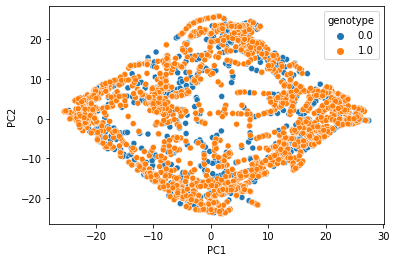

In [20]:
sns.scatterplot(data=df,x='PC1',y='PC2',hue='genotype')